# Gaussian Process Regression
## Part III - GPyTorch
## 2nd Machine Learning in Heliophysics
## Boulder, CO
### 21 - 25 March 2022

### Enrico Camporeale (University of Colorado, Boulder & NOAA Space Weather Prediction Center)
#### enrico.camporeale@noaa.gov
This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.<img align="right" width="88" height="31" src=https://i.creativecommons.org/l/by/4.0/88x31.png> <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">

GPyTorch is an highly efficient and modular implementation of GPs, with GPU acceleration.
Implemented in PyTorch.

Developed at Cornell University, Uber AI Labs, and Facebook.

https://gpytorch.ai/
http://github.com/cornellius-gp/gpytorch


## 1D regression

Example adapted from

https://docs.gpytorch.ai/en/v1.1.1/examples/01_Exact_GPs/Simple_GP_Regression.html

We want to solve a regression problem, where the underlying function is 

$f=\sin(2\pi x) + \varepsilon$, with $\varepsilon~\mathcal{N}(0,\sigma^2)$

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size': 22})
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Training data is 10 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 10)
# True function is sin(2*pi*x) with Gaussian noise
sigma = math.sqrt(0.04)

def f(x):
    f = torch.sin(x * (2 * math.pi))
    return (f)

train_y = f(train_x) + torch.randn(train_x.size()) * sigma

In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [4]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter=100
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: 1.212   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 1.195   lengthscale: 0.644   noise: 0.644
Iter 3/100 - Loss: 1.178   lengthscale: 0.598   noise: 0.598
Iter 4/100 - Loss: 1.161   lengthscale: 0.554   noise: 0.555
Iter 5/100 - Loss: 1.144   lengthscale: 0.513   noise: 0.514
Iter 6/100 - Loss: 1.126   lengthscale: 0.474   noise: 0.476
Iter 7/100 - Loss: 1.107   lengthscale: 0.438   noise: 0.441
Iter 8/100 - Loss: 1.085   lengthscale: 0.404   noise: 0.409
Iter 9/100 - Loss: 1.061   lengthscale: 0.372   noise: 0.378
Iter 10/100 - Loss: 1.035   lengthscale: 0.342   noise: 0.350
Iter 11/100 - Loss: 1.005   lengthscale: 0.314   noise: 0.323
Iter 12/100 - Loss: 0.972   lengthscale: 0.287   noise: 0.298
Iter 13/100 - Loss: 0.936   lengthscale: 0.262   noise: 0.274
Iter 14/100 - Loss: 0.900   lengthscale: 0.239   noise: 0.251
Iter 15/100 - Loss: 0.867   lengthscale: 0.217   noise: 0.229
Iter 16/100 - Loss: 0.839   lengthscale: 0.198   noise: 0.208
Iter 17/100 - Los

In [5]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 100)
    observed_pred = likelihood(model(test_x))

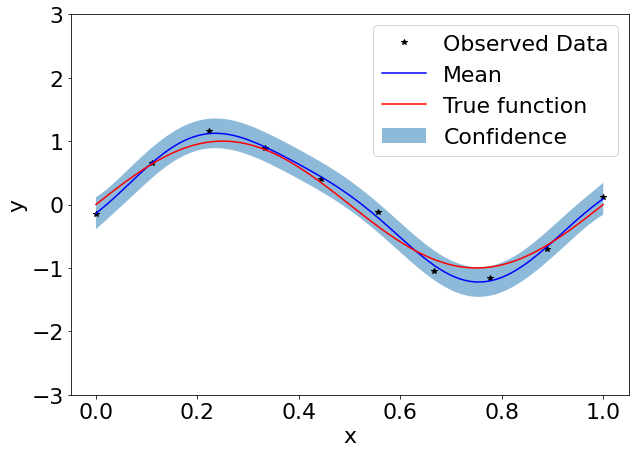

In [6]:
plt.rcParams.update({'font.size': 22})
with torch.no_grad():
    # Initialize plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca()
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Plot true function as red line
    ax.plot(test_x.numpy(), f(test_x).numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'True function', 'Confidence'])
    ax.set_xlabel('x', fontsize=22)
    ax.set_ylabel('y', fontsize=22)

## Non-uniform training data

Iter 1000/1000 - Loss: -0.735   lengthscale: 0.339   noise: 0.000


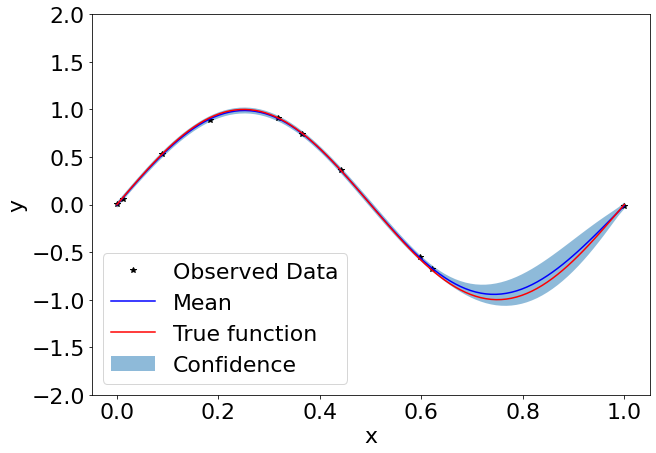

In [7]:
train_x = torch.linspace(0, 1, 10)
train_x *= torch.sin(2*math.pi*train_x) +1.0  # we dislocate the training point so they are non-uniform
sigma = 1e-2
train_y = f(train_x) + torch.randn(train_x.size()) * sigma

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
model.train()
likelihood.train()

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=1e-1)

# Try to change the number of iterations!
training_iter=1000  # We need now a larger number of iterations for training

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()


# Compare the mll here with the one for uniform training data    
print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))    
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 100)
    observed_pred = likelihood(model(test_x))
    # Initialize plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca()
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Plot true function as red line
    ax.plot(test_x.numpy(), f(test_x).numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-2, 2])
    ax.legend(['Observed Data', 'Mean', 'True function', 'Confidence'])
    ax.set_xlabel('x', fontsize=22)
    ax.set_ylabel('y', fontsize=22)

## Extrapolate to a region with no data

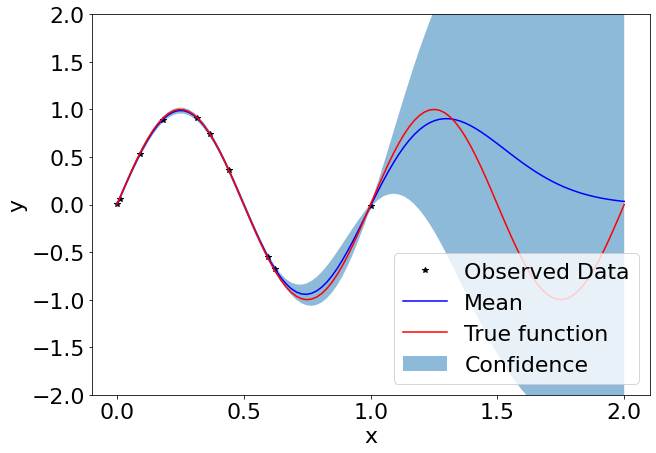

In [8]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 2, 100)
    observed_pred = likelihood(model(test_x))
    # Initialize plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca()
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Plot true function as red line
    ax.plot(test_x.numpy(), f(test_x).numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-2, 2])
    ax.legend(['Observed Data', 'Mean', 'True function', 'Confidence'])
    ax.set_xlabel('x', fontsize=22)
    ax.set_ylabel('y', fontsize=22)

In [9]:
from ipywidgets import interactive

initial_length = math.log(0.11)
initial_noise = math.log(0.03)

def interactive_f(lengthscale = initial_length, noise =initial_noise):
    model.covar_module.base_kernel.lengthscale = math.exp(lengthscale)
    model.likelihood.noise = math.exp(noise)
    test_x = torch.linspace(0, 1, 100)
    observed_pred = likelihood(model(test_x))
    # Initialize plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca()
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.detach().numpy(), 'b')
    # Plot true function as red line
    ax.plot(test_x.numpy(), f(test_x).detach().numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.set_ylim([-5, 5])
    ax.legend(['Observed Data', 'Mean', 'True function', 'Confidence'])
    ax.set_xlabel('x', fontsize=22)
    ax.set_ylabel('y', fontsize=22)
interactive_plot = interactive(interactive_f, lengthscale = (-4.0, 0.0), noise = (-5.0,0.0))
output = interactive_plot.children[-1]
    

In [10]:
interactive_plot

interactive(children=(FloatSlider(value=-2.2072749131897207, description='lengthscale', max=0.0, min=-4.0), Fl…

## A single training point separated from the others (not an outlier!)
### This is something that a neural network would have a hard time to capture well

Iter 1000/1000 - Loss: -0.550   lengthscale: 0.394   noise: 0.000


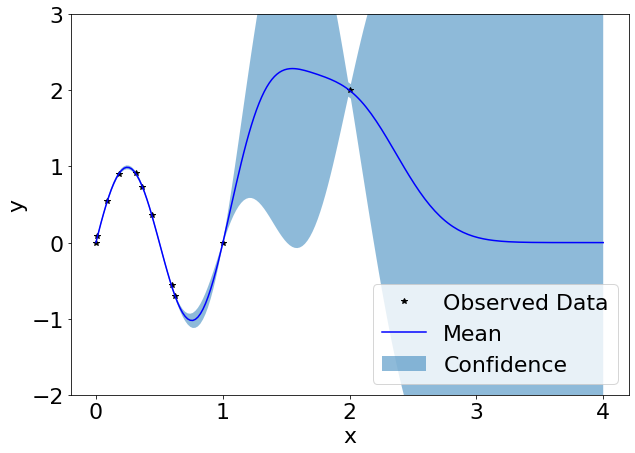

In [11]:
import numpy as np

train_x = torch.linspace(0, 1, 10)
train_x *= torch.sin(2*math.pi*train_x) +1.0  # we dislocate the training point so they are non-uniform
train_y = f(train_x) + torch.randn(train_x.size()) * sigma


train_x = torch.cat((train_x, torch.tensor([2.0])), 0)
train_y = torch.cat((train_y, torch.tensor([2.0])), 0)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
model.train()
likelihood.train()

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=1e-1)

# Try to change the number of iterations!
training_iter=1000  # We need now a larger number of iterations for training

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()


# Compare the mll here with the one for uniform training data    
print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))    
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 4.0, 200)
    observed_pred = likelihood(model(test_x))
    # Initialize plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca()
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Plot true function as red line
#    ax.plot(test_x.numpy(), f(test_x).numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-2, 3])
#    ax.legend(['Observed Data', 'Mean', 'True function', 'Confidence'])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_xlabel('x', fontsize=22)
    ax.set_ylabel('y', fontsize=22)

## Mean function

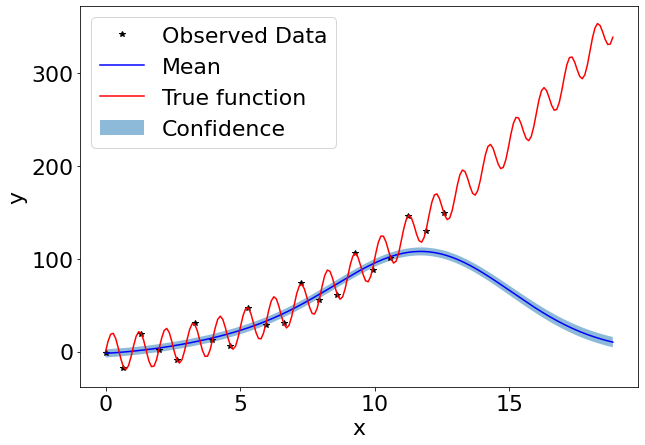

In [13]:
# Training data is 10 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 4*np.pi, 20)
# True function is sin(2*pi*x) with Gaussian noise
sigma = math.sqrt(0.04)

def f(x):
    f = 20*torch.sin(x * (2 * math.pi))+x**2
    return (f)

train_y = f(train_x) + torch.randn(train_x.size()) 


class MyMean(gpytorch.means.Mean):
    def forward(self, input):
      return torch.zeros(input.shape[:-1], dtype=input.dtype, device=input.device)
   #     return input[:,0]**2

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = MyMean() # gpytorch.means.ZeroMean()
     #   self.mean_module = gpytorch.means.ConstantMean()
   
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter=100
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
  #  print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
  #      i + 1, training_iter, loss.item(),
  #      model.covar_module.base_kernel.lengthscale.item(),
  #      model.likelihood.noise.item()
  #  ))
    optimizer.step()

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 6*np.pi, 200)
    observed_pred = likelihood(model(test_x))


plt.rcParams.update({'font.size': 22})
with torch.no_grad():
    # Initialize plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca()
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Plot true function as red line
    ax.plot(test_x.numpy(), f(test_x).numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
  #  ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'True function', 'Confidence'])
    ax.set_xlabel('x', fontsize=22)
    ax.set_ylabel('y', fontsize=22)

## The end!!